In [ ]:
from sklearn.datasets import make_circles
import torch
from torch import nn

In [ ]:
n_samples = 1000

X,y = make_circles(n_samples, noise=0.03,random_state=42)


In [ ]:
import pandas as pd

In [ ]:
circles = pd.DataFrame({"X1": X[:,0], 'X2':X[:,1], 'label': y })
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
# the number of each value that we have
circles.label.value_counts()

,count
label,
1,500
0,500


***visualize with a plot***

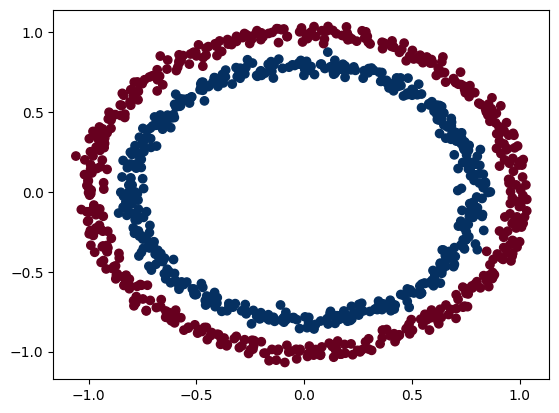

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdBu)

# convent our dataset to tensors

In [ ]:
# if gpu is avaliable, use it.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X = torch.from_numpy(X).type(torch.float).to(device) # numpy uses float64 but pytorch normally likes float 32
y = torch.from_numpy(y).type(torch.float).to(device)

In [ ]:
X = X.squeeze()
y = y.squeeze()

# Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)
len(X_train),len(y_train)

(800, 800)

# Time to build our model

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features= 5) #5 neurons
    self.layer_2 = nn.Linear(in_features = 5, out_features=1) # 1 neuron

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))



In [ ]:
# seeding
torch.manual_seed(42)
# create instance of circleModelV0
model_0 = CircleModelV0().to(device) # also use gpu if it's avaliable
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**Create an acccuracy metric**

In [ ]:
def accuracy(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item()
  accuracy = correct / len(y_pred)
  return accuracy

accuracy(y_pred=y_train, y_true=y_train)

1.0

In [ ]:
def train_model(model,epochs, lr):
  epochs_count = []
  train_losses = []
  test_losses = []

  # define loss function
  loss_fn = nn.BCEWithLogitsLoss()
  # define optimizer
  optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
  for epoch in range(epochs):
    # put model in training mode
    model.train()
    # calculate loss
    logit = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(logit))
    loss = loss_fn(logit, y_train)
    # calculate accuracy
    train_accuracy = accuracy(y_pred=y_pred, y_true=y_train)
    # zero grad
    optimizer.zero_grad()
    #perform backpropagation
    loss.backward()
    # update parameters
    optimizer.step()


    ##### evaluation ###########

    model.eval()
    with torch.inference_mode():
      test_logit = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))
      #calculate loss on test data
      test_loss = loss_fn(test_logit, y_test)
      # accuracy
      test_accuracy = accuracy(y_pred=test_pred, y_true=y_test)

    # on every tenth epoch, print something
    epochs_count.append(epoch)
    train_losses.append(loss.detach().item())
    test_losses.append(test_loss.detach().item())

    print(f"train loss {loss} accuracy {train_accuracy:.2f} | test loss {test_loss:}  accuracy {test_accuracy:.2f}")


In [ ]:
train_model(model=model_0, epochs=500, lr=0.01)

train loss 0.6929897665977478 accuracy 0.51 | test loss 0.6950352191925049  accuracy 0.47
train loss 0.6929897665977478 accuracy 0.52 | test loss 0.695034921169281  accuracy 0.47
train loss 0.6929897665977478 accuracy 0.52 | test loss 0.6950348019599915  accuracy 0.47
train loss 0.6929897665977478 accuracy 0.52 | test loss 0.6950344443321228  accuracy 0.47
train loss 0.6929897665977478 accuracy 0.52 | test loss 0.6950341463088989  accuracy 0.47
train loss 0.6929897665977478 accuracy 0.52 | test loss 0.6950339078903198  accuracy 0.47
train loss 0.6929896473884583 accuracy 0.52 | test loss 0.695033609867096  accuracy 0.47
train loss 0.692989706993103 accuracy 0.52 | test loss 0.6950333714485168  accuracy 0.47
train loss 0.692989706993103 accuracy 0.52 | test loss 0.695033073425293  accuracy 0.47
train loss 0.692989706993103 accuracy 0.52 | test loss 0.6950328946113586  accuracy 0.47
train loss 0.6929896473884583 accuracy 0.52 | test loss 0.6950326561927795  accuracy 0.47
train loss 0.692

# download helper functions for visualization

In [ ]:
import requests
from pathlib import Path

In [ ]:
# download helper function for visualization
if Path('helper_function.py').is_file():
  print('helper function alreday exists')
else:
  print('downloading helper_function.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_function.py','wb') as f:
    f.write(request.content)

downloading helper_function.py


In [ ]:
from helper_function  import plot_decision_boundary

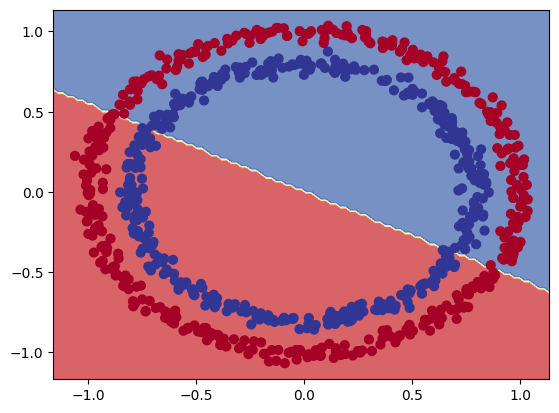

In [ ]:
plot_decision_boundary(model_0, X_train, y_train)

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features= 10) #5 neurons
    self.layer_2 = nn.Linear(in_features = 10, out_features=1) # 1 neuron
    self.relu = nn.ReLU()

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    z0 = self.layer_1(x)
    a0 = self.relu(z0)
    z1 =  self.layer_2(a0)
    a1 = self.relu(z1)
    return a1



In [100]:
model_1 = CircleModelV1().to(device)
train_model(model_1, 100000, 0.01)

Streaming output truncated to the last 5000 lines.
train loss 0.3585343062877655 accuracy 0.98 | test loss 0.37973693013191223  accuracy 0.92
train loss 0.3585328161716461 accuracy 0.98 | test loss 0.3797302842140198  accuracy 0.92
train loss 0.35853293538093567 accuracy 0.98 | test loss 0.37976211309432983  accuracy 0.92
train loss 0.35853302478790283 accuracy 0.98 | test loss 0.3797312080860138  accuracy 0.92
train loss 0.35853251814842224 accuracy 0.98 | test loss 0.3797246515750885  accuracy 0.92
train loss 0.3585323989391327 accuracy 0.98 | test loss 0.37976524233818054  accuracy 0.92
train loss 0.3585326373577118 accuracy 0.98 | test loss 0.37973424792289734  accuracy 0.92
train loss 0.3585318326950073 accuracy 0.98 | test loss 0.37972769141197205  accuracy 0.92
train loss 0.3585317134857178 accuracy 0.98 | test loss 0.3797682225704193  accuracy 0.92
train loss 0.35853222012519836 accuracy 0.98 | test loss 0.3797371983528137  accuracy 0.92
train loss 0.35853126645088196 accuracy 

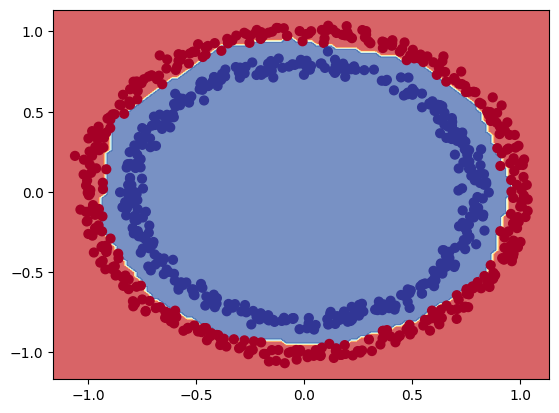

In [101]:
plot_decision_boundary(model_1, X_train, y_train)